In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import numpy as np, os, sys, time, pandas as pd, tensorflow as tf, random
start_time = time.time()
import keras
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.callbacks import ReduceLROnPlateau
path = "/content/drive/My Drive/jöklar/"
sys.path.append(path + "src")
from util.util import install_import
rasterio = install_import("rasterio")
from numpy import flatnonzero as find
from osgeo import gdal

In [ ]:
# Define model type and data to use
modeltype = "unet"
augmentation = True
dataname = "lang"
model_path = path + "results/" + modeltype + "/"
data_path = path + "data/" + dataname + "/"
os.makedirs(model_path, exist_ok=True)
os.chdir(model_path)

In [ ]:
def load_images(nfiles = "all"):
  # Load individual image and mask files, determine glacier border tiles
  (img, mask, row, col) = np.load(data_path + "data.npz").values()
  n_channels = img.shape[-1]
  if nfiles == "all":
    nfiles = len(mask)
  return img, mask, row, col

In [ ]:
def get_border_indices(img, mask):
  # Load individual image and mask files, determine glacier border tiles
  ntiles = len(img)
  glacier_fraction = np.zeros(ntiles)
  meta = []
  for i in range(ntiles):
    glacier_fraction[i] = np.sum(mask[i] != 0) / mask[i].size
  is_on_border = [0.01 < g < 0.99 for g in glacier_fraction]
  count = sum(is_on_border)
  border_indices = find(is_on_border)
  return border_indices

In [ ]:
# Import project-specific packages

# NOTES
# deeplab-v3+ is copied more or less directly from the github repository
#    github.com/david8862/tf-keras-deeplabv3p-model-set
# (the original files are in the subdirectory from_github, cf differences.txt)
#
# unet is copied from...

match modeltype:
  case "unet":
    from models.unet import get_unet
  case "deeplab":
    install_import("keras_applications")
    from models.deeplabv3p import model

In [ ]:
# Read image data and data splits and define X and Y for training and test
# %%time
# npzfile = data_path + "images.npz"
# (img, mask, is_on_border, train, val, test) = np.load(npzfile).values()

In [ ]:
def create_model(modeltype):
  match modeltype:
    case "unet":
      input_img = keras.layers.Input((256, 256, 13), name='img')
      Adam_params = {"learning_rate":1e-4, "clipnorm":1.0}
      model = get_unet(input_img, n_filters=64, dropout=0.2, batchnorm=True)

    case "deeplab":
      Adam_params = {"learning_rate":1e-4}
      get_deeplab = model.get_deeplabv3p_model
      model = get_deeplab(model_type='resnet50', num_classes=1,
                          model_input_shape=(256,256),
                          output_stride=16,
                          freeze_level=0,
                          weights_path=None,
                          training=True,
                          use_subpixel=False)

  model.compile(optimizer = Adam(**Adam_params),
                loss="binary_crossentropy",
                metrics=["accuracy"])
  model.save('model_first.keras')
  return model
  # NOTE: Saving weights only gives a file just as big as saving the whole model

In [ ]:
def define_callbacks(modeltype):
  match modeltype:
    case "unet":
      early_stopping = EarlyStopping(patience=15, verbose=1)
      reduce_LR_on_plateau = ReduceLROnPlateau(factor=0.1,
                                              patience=7,
                                              min_lr=0.00001,
                                              verbose=1),

    case "deeplab":
      early_stopping = EarlyStopping(min_delta=0.01,
                                    patience=40,
                                    verbose=1,
                                    monitor='val_loss',
                                    restore_best_weights=True)
      reduce_LR_on_plateau = ReduceLROnPlateau(factor=0.1,
                                              patience=10,
                                              min_lr=1e-12,
                                              verbose=1)
  checkpoint_best = ModelCheckpoint('model_best.keras',
                                    verbose=1,
                                    monitor="val_loss",
                                    save_weights_only=True,
                                    save_best_only=True)
  checkpoint_last = ModelCheckpoint('model_last.keras',
                                    save_weights_only=True)
  callbacks = [
      EarlyStopping(patience=60, verbose=1),
      ReduceLROnPlateau(factor=0.3, patience=10, min_lr=0.00001, verbose=1),
      checkpoint_best,
      checkpoint_last,
  ]
  return callbacks

In [ ]:
def train_val_test_split(border_indices):
  # Define data split (training, validation, and test sets)
  seed = 47
  tf_seed = 45
  random.seed(seed)
  np.random.seed(seed)
  tf.random.set_seed(tf_seed)
  test_size = 0.15
  train_size = 0.18  # or 0.15/(1 - test_size)
  temp, test = train_test_split(border_indices, test_size = test_size, random_state=seed)
  train, val = train_test_split(temp, test_size = train_size, random_state=seed)
  return train, val, test

In [ ]:
def albumentations_generator(img, mask, train):
  # Implement data augmentation with the albumentations package
  augmentation = {
      "random_gamma_probability": 0.5,
      "random_gamma_gamma_limit": [80, 120],
      "flipud_probability": 0.5,
      "fliplr_probability": 0.5,
      "rotate90_probability": 0.5,
      "random_crop_probability": 0.5,
      "random_crop_height": 256,
      "random_crop_width": 256,
      "random_crop_scale_x": 0.5,
      "random_crop_scale_y": 0.5
  }
  from util.generator import AugmentDataGenerator
  train_gen = AugmentDataGenerator(img[train], mask[train], augmentation)
  return train_gen

In [ ]:
(imgraw, mask, row, col) = load_images()
border_indices = get_border_indices(imgraw, mask)
dtype = imgraw.dtype
ntile = len(imgraw)
nchan = imgraw.shape[-1]
nborder = len(border_indices)
img = imgraw/1000
print(f"{nchan} channels, {ntile} tiles, {nborder} on border, datatype: {dtype}")

13 channels, 197 tiles, 105 on border, datatype: uint16


In [ ]:
(train, val, test) = train_val_test_split(border_indices)
if augmentation:
  data_input = (albumentations_generator(img, mask, train),)
else:
  data_input = (img[train], mask[train])
model = create_model(modeltype)
callbacks = define_callbacks(modeltype)

In [ ]:
# Train (save best results, and possibly all)
do_train = True
if do_train:
  results = model.fit(*data_input,
                      batch_size = 8 if model=="deeplab" else 8,
                      epochs = 60,
                      callbacks = callbacks,
                      validation_data=(img[val], mask[val]))
  history = results.history
else:
  model = tf.keras.models.load_model('model_best.h5')
  history = pd.read_csv('result_history.csv')

Epoch 1/60
71/72 [============================>.] - ETA: 0s - loss: 0.8190 - accuracy: 0.5042
Epoch 1: val_loss improved from inf to 1.84997, saving model to model_best.keras
72/72 [==============================] - 31s 187ms/step - loss: 0.8144 - accuracy: 0.5097 - val_loss: 1.8500 - val_accuracy: 0.5859 - lr: 1.0000e-04
Epoch 2/60
71/72 [============================>.] - ETA: 0s - loss: 0.7160 - accuracy: 0.5418
Epoch 2: val_loss improved from 1.84997 to 0.73257, saving model to model_best.keras
72/72 [==============================] - 3s 42ms/step - loss: 0.7165 - accuracy: 0.5412 - val_loss: 0.7326 - val_accuracy: 0.5116 - lr: 1.0000e-04
Epoch 3/60
71/72 [============================>.] - ETA: 0s - loss: 0.7087 - accuracy: 0.5412
Epoch 3: val_loss improved from 0.73257 to 0.67148, saving model to model_best.keras
72/72 [==============================] - 3s 45ms/step - loss: 0.7087 - accuracy: 0.5405 - val_loss: 0.6715 - val_accuracy: 0.5983 - lr: 1.0000e-04
Epoch 4/60
71/72 [======

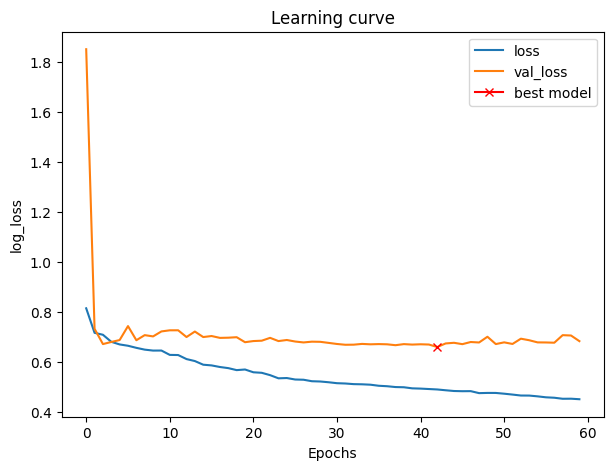

In [ ]:
# Plot learning curve
import matplotlib.pyplot as plt
plt.figure(figsize=(7, 5))
plt.title("Learning curve")
plt.plot(history["loss"], label="loss")
plt.plot(history["val_loss"], label="val_loss")
plt.plot(np.argmin(history["val_loss"]),
        np.min(history["val_loss"]),
        marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

1/1 [==============================] - 3s 3s/step - loss: 0.7025 - accuracy: 0.5458
Accuracy on test: 0.5457763671875


(array([  48369.,  254713.,  670667., 1547331., 3843575., 1392998.,
        1423630., 1303214.,  885949., 1540146.]),
 array([8.85320129e-04, 9.85390246e-02, 1.96192726e-01, 2.93846428e-01,
        3.91500145e-01, 4.89153832e-01, 5.86807549e-01, 6.84461236e-01,
        7.82114923e-01, 8.79768670e-01, 9.77422357e-01]),
 <BarContainer object of 10 artists>)

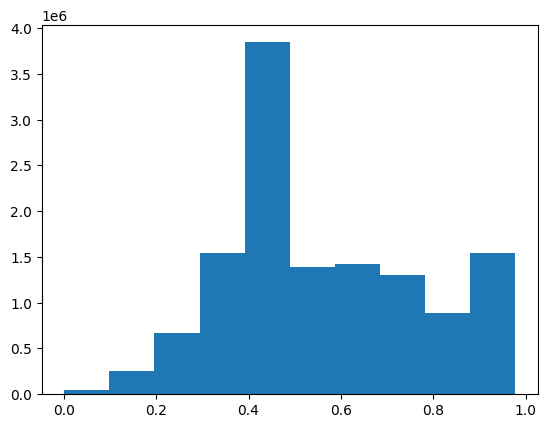

In [ ]:
# Compute predicted probabilites everywhere; evaluate on test
probs = model.predict(img, verbose=1)
(test_loss, test_accuracy) = model.evaluate(img[test], mask[test])
print(f'Accuracy on test: {test_accuracy}')
plt.hist(probs.ravel())

In [ ]:
# Save the training history and model predictions
pdhistory = pd.DataFrame(history)
pdhistory.to_csv("result_history.csv")
np.savez("probs.npz", probs, test_loss, test_accuracy)

In [ ]:
# Display running time and disconnect
end_time = time.time()
min, sec = divmod(int(end_time - start_time), 60)
print(f"Total execution time: {min}:{sec:02}")

Total execution time: 5:22


In [ ]:
%%time
data = np.load(data_path + "data.npz")
x = data['image']

CPU times: user 2.52 s, sys: 165 ms, total: 2.69 s
Wall time: 3 s


In [ ]:
from google.colab import runtime
runtime.unassign()